In [7]:
import pandas as pd
import json

# Paths to the JSON files
file_paths = [
    r"C:\Users\PC\Downloads\json_thesis\mistral_arts_tf_results_0_12490.json",
    r"C:\Users\PC\Downloads\json_thesis\mistral_arts_tf_results_12491_25431.json",
    r"C:\Users\PC\Downloads\json_thesis\mistral_arts_tf_results_25432_32970.json"
]

# Define keywords for creator and year questions for each language
location_keywords = {
    'EN': [" created by"],
    'FR': [" a-t-il été créé pa"],
    'DE': ["von", "erstellt"],
    'TR': [" tarafından mı yaratıldı?"],
    'JA': ["によって作られましたか"]
}

year_keywords = {
    'EN': ["completed in"],
    'FR': ["a-t-il été achevé en"],
    'DE': ["fertiggestellt"],
    'TR': [" yılında mı tamamlandı"],
    'JA': ["年に完成しましたか"]
}
# Function to load JSON file and convert to DataFrame
def load_json_to_df(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    df = pd.DataFrame(data)
    return df

# Function to classify question type based on keywords
def get_question_type(question, language, index, total):
    if language not in artist_keywords or language not in year_keywords:
        return "Other"
    
    # Specific handling for French to split equally
    if language == 'FR':
        # If total French questions are even, split equally
        # If odd, the extra will be classified as Location
        mid_point = total // 2
        if index < mid_point:
            return "Artist"
        else:
            return "Year"
    
    for keyword in location_keywords[language]:
        if keyword.lower() in question.lower():
            return "Artist"
    for keyword in year_keywords[language]:
        if keyword.lower() in question.lower():
            return "Year"
    return "Other"

# Initialize a DataFrame to store combined data
combined_df = pd.DataFrame()

# Load data from the JSON files
for file_path in file_paths:
    df = load_json_to_df(file_path)
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# Count the total number of French questions
total_french = combined_df[combined_df['Language'] == 'FR'].shape[0]

# Apply the question type classification
def classify_row(row):
    if row['Language'] == 'FR':
        index = row.name % total_french  # Use the row index within French rows
        return get_question_type(row['Question'], row['Language'], index, total_french)
    else:
        return get_question_type(row['Question'], row['Language'], None, None)

combined_df['question_type'] = combined_df.apply(classify_row, axis=1)



In [8]:
combined_df

,Question,Model_Answer,Actual_Answer,Compared_Answer,Language,Time_Taken,question_type
0,"Was First Town hall, Pushkin town created by C...","Comment: I don't know,",False,0,EN,1.080448,Artist
1,"Was First Town hall, Pushkin town completed in...",Comment: False. The construction of the,True,0,EN,0.558748,Year
2,Was Khuk Khi Kai created by French Indochina?,False. Khuk Khi Kai,True,0,EN,0.561770,Artist
3,Was Khuk Khi Kai completed in 1992?,Answer: False.\n\nK,False,1,EN,0.559169,Year
4,Was Statue of Liberty created by Bertel Nilsson?,False.\n\nComment: @JamesK,False,1,EN,0.556675,Artist
...,...,...,...,...,...,...,...
32963,絹本著色後醍醐天皇御像 は 1339 年に完成しましたか？,True.\n\nThe gilded,True,1,JA,0.586420,Year
32964,花園天皇像 は 藤原豪信 によって作られましたか？,True.\n\nThe statue of the,True,1,JA,0.585298,Artist
32965,花園天皇像 は 1338 年に完成しましたか？,答：偽。花園,True,0,JA,0.585081,Year
32966,Mount Fuji and the Pine Beach at Miho は 森徹山 によ...,True. Mount Fuji and the P,True,1,JA,0.587040,Artist


In [9]:
#filtered_df = dfs['French People'][dfs['English People']['Language'] == 'TR'].head(50)
#print(filtered_df)

In [10]:
# Function to extract 'Other' entries for inspection
def extract_other_entries(df, num_samples=10):
    other_df = df[df['question_type'] == 'Other']
    return other_df.sample(min(num_samples, len(other_df)), random_state=1)

# Extract 'Other' entries for inspection
other_entries = extract_other_entries(combined_df)

# Display the 'Other' entries
print("Entries classified as 'Other':")
print(other_entries)

# Display summary statistics by language
summary = combined_df.groupby(['Language', 'question_type']).size().unstack(fill_value=0)
print("Summary statistics by language:")
print(summary)

Entries classified as 'Other':
Empty DataFrame
Columns: [Question, Model_Answer, Actual_Answer, Compared_Answer, Language, Time_Taken, question_type]
Index: []
Summary statistics by language:
question_type  Artist  Year
Language                   
DE               3351  3243
EN               3297  3297
FR               3296  3297
JA               3297  3297
TR               3297  3296


In [11]:
combined_df.to_csv('tf_arts.csv', index=False)

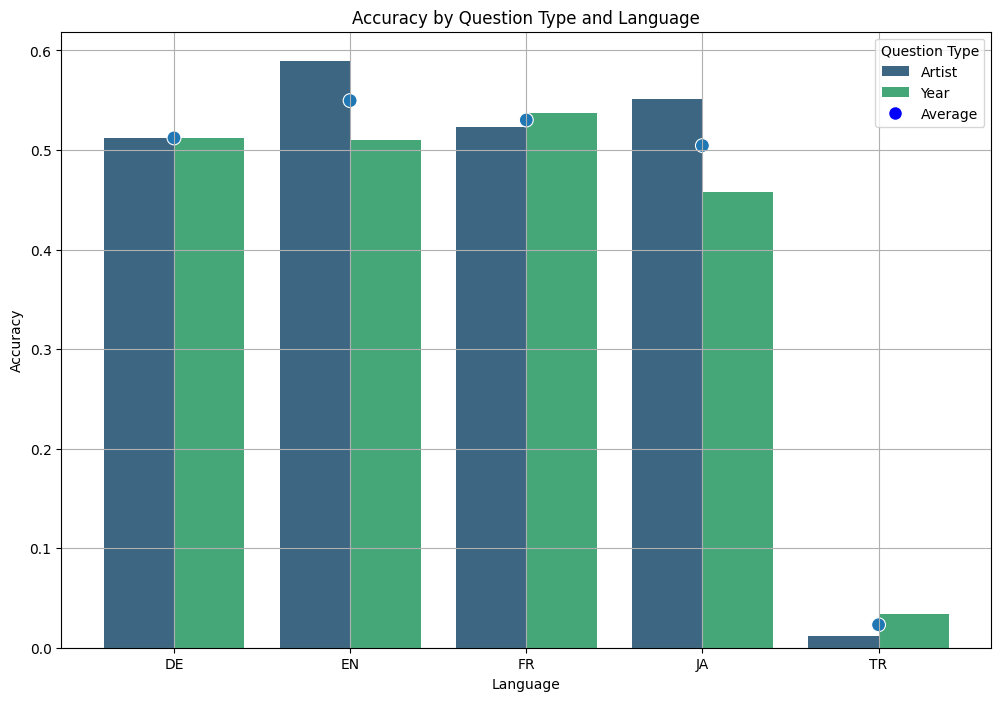

In [58]:
# Calculate the accuracy for each group of question type and language
accuracy_df = combined_df.groupby(['Language', 'question_type'])['Compared_Answer'].value_counts(normalize=True).unstack().fillna(0)
accuracy_df['Accuracy'] = accuracy_df[1]  # Accuracy is the proportion of 1s
accuracy_df = accuracy_df.reset_index()

# Filter only "Location" and "Year" question types
filtered_accuracy_df = accuracy_df[accuracy_df['question_type'].isin(['Artist', 'Year'])]

# Calculate the average accuracy for each language
average_accuracy_df = filtered_accuracy_df.groupby('Language')['Accuracy'].mean().reset_index()
average_accuracy_df['question_type'] = 'Average'

# Combine the average accuracy with the filtered accuracy data
combined_accuracy_df = pd.concat([filtered_accuracy_df, average_accuracy_df], ignore_index=True)

# Plot the accuracies
plt.figure(figsize=(12, 8))

# Bar plot for Location and Year questions
sns.barplot(x='Language', y='Accuracy', hue='question_type', data=filtered_accuracy_df, palette='viridis')

# Scatter plot for Average accuracy
sns.scatterplot(x='Language', y='Accuracy', hue='question_type', style='question_type', data=average_accuracy_df, markers=['o'], s=100, color='blue', legend=False)

# Add a custom legend for the average dots
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Average', markersize=10, markerfacecolor='blue'))
labels.append('Average')

plt.legend(handles=handles, title='Question Type')
plt.xlabel('Language')
plt.ylabel('Accuracy')
plt.title('Accuracy by Question Type and Language')
plt.grid(True)
plt.show()

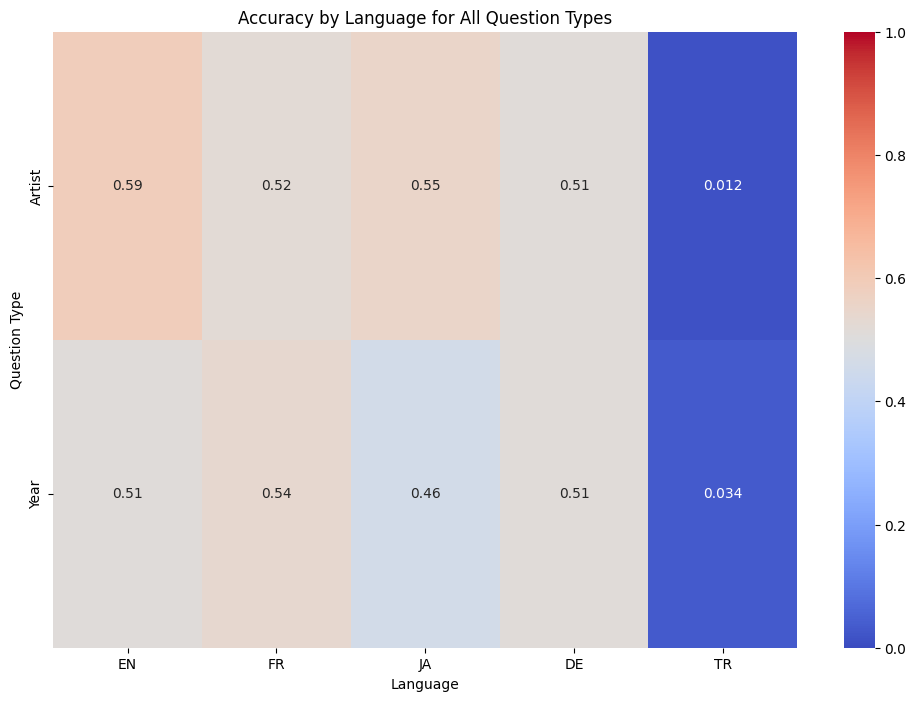

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the order for groups and languages
language_order = ['EN', 'FR', 'JA', 'DE', 'TR']

# Calculate the accuracy for each group of question type and language
accuracy_df = combined_df.groupby(['question_type', 'Language'])['Compared_Answer'].value_counts(normalize=True).unstack().fillna(0)
accuracy_df['Accuracy'] = accuracy_df[1]  # Accuracy is the proportion of 1s
accuracy_df = accuracy_df.reset_index()

# Filter only "Location" and "Year" question types
filtered_accuracy_df = accuracy_df[accuracy_df['question_type'].isin(['Artist', 'Year'])]

# Create a pivot table for the heat map
pivot_df = filtered_accuracy_df.pivot_table(index='question_type', columns='Language', values='Accuracy')

# Reorder the languages in the pivot table
pivot_df = pivot_df[language_order]

# Plot a combined heatmap for all question types
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.xlabel('Language')
plt.ylabel('Question Type')
plt.title('Accuracy by Language for All Question Types')
plt.show()
